# Pomegranate Tutorial 1: Distributions

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

This tutorial will cover the Distributions library, showing the various distributions, their use cases, and how to fully use it. To start off with, the list of distributions currently supported by pomegranate are the following:

<ul>
  <li> UniformDistribution
  <li> NormalDistribution
  <li> LogNormalDistribution
  <li> ExponentialDistribution
  <li> BetaDistribution
  <li> GammaDistribution
  <li> DiscreteDistribution
  <li> LambdaDistribution
  <li> GaussianKernelDensity
  <li> UniformKernelDensity
  <li> TriangleKernelDensity
  <li> IndependentComponentsDistribution
  <li> MultivariateGaussianDistribution
  <li> ConditionalProbabilityTable
  <li> JointProbabilityTable
</ul>

The following methods are supported by all distributions:

```
copy() : Make a deep copy of the distribution
freeze() : Prevent the distribution from updating on training calls
thaw() : Reallow the distribution to update on training calls
log_probability( symbol ): Return the log probability of the symbol under the distribution
sample() : Return a randomly generated sample from the distribution
fit / train / from_sample( items, weights=None, inertia=None ) : Update the parameters of the distribution
summarize( items, weights=None ) : Store sufficient statistics of a dataset for a future update
from_summaries( inertia=0.0 ) : Update the parameters of the distribution from the sufficient statistics
to_json() : Return a json formatted string representing the distribution
from_json( s ) : Build an appropriate distribution object from the string
```

Univariate distributions also have a `plot( n=1000, **kwargs )` command, where you can plot a histogram of `n` randomly generated samples from the distribution, which will pass matplotlib keyword arguments to the `plt.hist` function. 

Lets look at a few examples.

## The Normal Distribution

In [1]:
from pomegranate import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Lets start off by looking at a normal distribution. It is easy to specify, and take a look at.

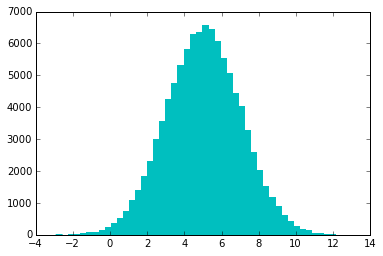

In [2]:
d = NormalDistribution( 5, 2 )
d.plot( n=100000, edgecolor='c', color='c', bins=50 )

We can then calculate the log probability of some points under this distribution.

In [3]:
print d.log_probability( 1 )
print d.log_probability( 5 )
print d.log_probability( 9 )

-3.61208571376
-1.61208571376
-3.61208571376


We can also fit this distribution to some data we have.

In [4]:
data = np.random.randn(10000) * 0.4 + 9

[8.99861968524466, 0.39755567939702824]


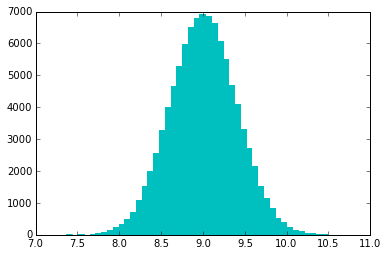

In [5]:
d.fit( data )
d.plot( n=100000, edgecolor='c', color='c', bins=50 )
print d.parameters

We generated data from a normal distribution with mean 9 and standard deviation 0.4, and we can see that the distribution object was able to recover it. This is not surprising given the amount of data it received.

The fitting process discards the previous parameters, and uses a pure MLE estimate on the new data. In this case, it just takes the mean and variance of the new data, discarding its previous parameters. It does not matter if the previous distribution was `NormalDistribution(1, 5)` or `NormalDistribution(10000000, 10000000)`, they would both recover the same parameters after.

A way of taking into account current parameters is by using inertia, where the update is equal to `previous parameters * inertia + new parameters * ( 1 - inertia )`. This allows the update to take into account prior parameters a bit. Lets see an example.

In [6]:
d = NormalDistribution( 10, 1 )
e = NormalDistribution( 200, 1 )

d.fit( data, inertia=0.0 ) # The default setting
e.fit( data, inertia=0.5 )

print "d -- mu: {} sigma {}".format( *d.parameters )
print "e -- mu: {} sigma {}".format( *e.parameters )

d -- mu: 8.99861968524 sigma 0.397555679397
e -- mu: 104.499309843 sigma 0.698777839699


Out of core updates are also supported for distributions. This means that we can update a distribution using an amount of data which cannot fit into memory normally, but still produce an exact update. This is done by summarizing the dataset into sufficient statistics at each step, and then producing an update at the end. 

In [7]:
d = NormalDistribution( 105, 12 )

for i in range(10):
    d.summarize( data[i::10] )

d.from_summaries()
print "d -- mu: {} sigma {}".format( *d.parameters )

d -- mu: 8.99861968524 sigma 0.397555679397


In this particular case, the data can all fit in memory, but it doesn't necessarily have to. You just have to call `summarize`, then load up the next set of data, and continue.

If we want to weight points, we can easily pass in a weight vector. Weights must be non-negative, and the sum of the weight vector must be greater than 0. Numerical stability issues can arise if you have entirely small weight vectors, so try to avoid that if possible.

In [8]:
d = NormalDistribution( 105, 12 )
weights = np.random.exponential( 100, 10000 )
d.fit( data, weights )

print "d -- mu: {} sigma {}".format( *d.parameters )

d -- mu: 8.99430310588 sigma 0.39259189004


It doesn't change much in this case since the data was drawn from a perfect normal distribution, but it illustrates the possibility. The analog for summarization is the following:

In [9]:
d = NormalDistribution( 105, 12 )

for i in range(10):
    d.summarize( data[i::10], weights=weights[i::10] )

d.from_summaries()
print "d -- mu: {} sigma {}".format( *d.parameters )

d -- mu: 8.99430310588 sigma 0.392591890039


We can also easily sample from distributions by calling the `sample` function. `plot` does this internally when we call it, but to be explicit lets reproduce that.

(array([  3.00000000e+00,   7.00000000e+00,   1.50000000e+01,
          3.60000000e+01,   8.40000000e+01,   1.71000000e+02,
          2.28000000e+02,   4.65000000e+02,   6.89000000e+02,
          8.49000000e+02,   1.04600000e+03,   1.16200000e+03,
          1.21700000e+03,   1.16100000e+03,   9.73000000e+02,
          7.16000000e+02,   5.08000000e+02,   3.16000000e+02,
          1.84000000e+02,   9.10000000e+01,   4.70000000e+01,
          2.50000000e+01,   3.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([  60.62589314,   64.28006742,   67.93424169,   71.58841597,
          75.24259025,   78.89676453,   82.55093881,   86.20511309,
          89.85928737,   93.51346165,   97.16763592,  100.8218102 ,
         104.47598448,  108.13015876,  111.78433304,  115.43850732,
         119.0926816 ,  122.74685588,  126.40103016,  130.05520443,
         133.70937871,  137.36355299,  141.01772727,  144.67190155,
         148.32607583,  151.98025011]),
 <a list of 25 Patch objects

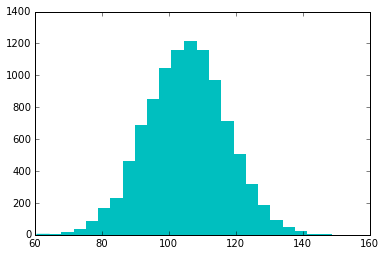

In [10]:
d = NormalDistribution( 105, 12 )
samples = [ d.sample() for i in range(10000) ]
plt.hist( samples, edgecolor='c', color='c', bins=25 )

## The Discrete Distribution

A notable deviant from the numerics logic is the Discrete Distribution. Instead of passing parameters as floats, you instead pass in a dictionary where keys can be ~any object~ and values are the probability of them occurring. If you try to calculate the log probability of an item not present in the distribution, the default behavior is to return negative infinity.

In [11]:
d = DiscreteDistribution({'A': 0.1, 'C': 0.25, 'G': 0.50, 'T': 0.15})
print d.log_probability( 'A' )
print d.log_probability( 'G' )
print d.log_probability( '????' )

-2.30258509299
-0.69314718056
-inf


Updating a discrete distributon is the same as updating other distributions.

In [12]:
items = list('ACGATACACTGAATGACAGCAGTCACTGACAGTAGTACGAGTAGTAGCAGAGAGTAATAAAGAATTAATATATGACACTACGAAAAAAATGCATCG')
d.fit( items )

for char in 'ACGT':
    print "logp({}) = {}".format( char, d.log_probability( char ) )

print d.parameters

logp(A) = -0.826678573184
logp(C) = -1.85629799037
logp(G) = -1.56861591791
logp(T) = -1.6199092123
[{'A': 0.4375, 'C': 0.15625, 'T': 0.19791666666666666, 'G': 0.20833333333333334}]


We can also take a look at the JSON serialization. JSONs are the perfect way to store these models given their human interpretability, and the ability to recursively store JSONs within other JSONs, such as more complicated models (such as HMMs) will need to store the JSON of each distribution. It is useful to store these models after the computationally intensive task of training them, so that it need not be repeated.

In [13]:
print d.to_json()

{
    "frozen" : false,
    "class" : "Distribution",
    "parameters" : [
        {
            "A" : 0.4375,
            "C" : 0.15625,
            "T" : 0.19791666666666666,
            "G" : 0.20833333333333334
        }
    ],
    "name" : "DiscreteDistribution"
}


## The Kernel Density

The Gaussian Kernel Density is a non-parametric distribution which stores a series of points, their associated weights, and the bandwidth representing the range of influence of each point. This will become apparent with an example.

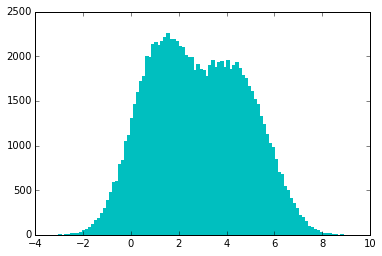

In [14]:
d = GaussianKernelDensity( [0.5, 1.2, 4.2, 1.9, 5.4, 3.4], bandwidth=1 )
d.plot( n=100000, edgecolor='c', color='c', bins=100 )

Changing the bandwidth parameter is equivalent to reducing the variance on a Gaussian. It makes the densities more central around the points, but can cause overfitting.

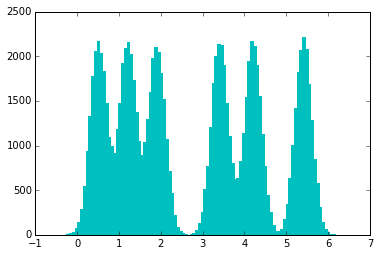

In [15]:
d = GaussianKernelDensity( [0.5, 1.2, 4.2, 1.9, 5.4, 3.4], bandwidth=0.2 )
d.plot( n=100000, edgecolor='c', color='c', bins=100 )

We can easily see the influence of weights by weighting a single point. 

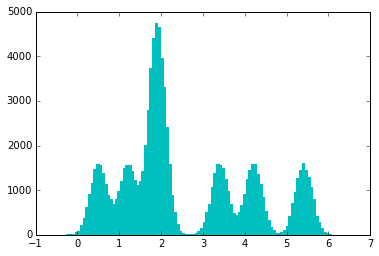

In [16]:
d = GaussianKernelDensity( [0.5, 1.2, 4.2, 1.9, 5.4, 3.4], weights=[1, 1, 1, 3, 1, 1], bandwidth=0.2 )
d.plot( n=100000, edgecolor='c', color='c', bins=100 )

In addition to the Gaussian kernel density, there is a Triangle kernel density, which has a slightly different shape. Mostly I liked how they looked like pointy hats, so I implemented it.

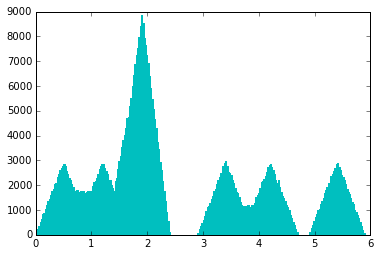

In [17]:
d = TriangleKernelDensity( [0.5, 1.2, 4.2, 1.9, 5.4, 3.4], weights=[1, 1, 1, 3, 1, 1], bandwidth=0.5 )
d.plot( n=500000, edgecolor='c', color='c', bins=250 )

## Independent Components Distribution

Sometimes, a univariate distribution isn't good enough. Many times data comes in the form of multiple, independent, dimensions, each with their own distribution. We can model this with a multivariate distribution which contains a tuple of independent components. 

A common example may be to look at data whose signal is normally distributed, and whose duration is modelled by an exponential. 

In [18]:
d = IndependentComponentsDistribution([ NormalDistribution(10, 1), ExponentialDistribution(0.5) ])
print d.log_probability( (11, 3) )

-3.61208571376


We can also weight the distributions. In this example, lets say that the signal is far more important than the duration.

In [19]:
d = IndependentComponentsDistribution([ NormalDistribution(10, 1), ExponentialDistribution(0.5) ], weights=[3, 1])
print d.log_probability( (11, 3) )

-2.5134734251


We see that the point becomes more probable, because we care more about the good fit to the signal dimension (the normal distribution) than it poorly fits the duration (exponential) distribution. You must be careful with the weightings though, because they don't have to sum to 1. In this sense, `weights = [3,1]` is not the same as `weights = [0.75, 0.25]`. 

We can do updates in the same manner. Drawing sampels from a Gaussian with `mu = 12` and `sigma = 2`, and an exponential with `mu = 5` (0.2 in pomegranate notation, which is more prominent), we can recover the underlying distributions with 1000 points.

In [20]:
data = numpy.zeros((1000, 2))
data[:,0] = np.random.randn(1000) * 2 + 12 
data[:,1] = np.random.exponential(5, 1000)
d.fit(data)

print d.parameters[0][0].parameters, d.parameters[0][1].parameters

[12.030799922655598, 1.977784472467497] [0.19699365419344794]


## Multivariate Gaussian Distribution

It's not always good enough to have independent distributions, as many signals are heavily correlated. A simple multivariate Gaussian has been written, as this is the most common use case, with full covariance updates. You provide a vector of mus, and a covariance matrix, and you're good to go! Unfortunately, plotting is not natively supported for this distribution.

In [21]:
d = MultivariateGaussianDistribution( np.arange(5) * 5, np.eye(5) )
print d.sample()

[  1.74658287   5.04598061   9.37220759  15.59744425  20.40541947]


In [22]:
data = np.random.randn(1000, 5) + np.arange(5) * 8

d.fit(data)
print d.parameters

[[-0.04512195463707575, 8.002536121450724, 16.038758646102238, 23.992721758840425, 32.01862280430998], [[0.9729529469569379, 0.01571487135218882, 0.01313375134308967, 0.0024544702051427975, 0.016218389127761156], [0.01571487135218882, 1.0238162403913156, -0.017572818860106053, -0.030104127335333034, -0.015939632105786587], [0.01313375134308967, -0.017572818860091502, 1.019248933473631, -0.007044888628821354, -0.008670178276312071], [0.002454470205143025, -0.030104127335333034, -0.007044888628821354, 0.9917274083149387, 0.011086647133459337], [0.016218389127761385, -0.015939632105786587, -0.008670178276312071, 0.011086647133459337, 0.9611708979294635]]]


In [23]:
print d.sample()

[ -0.66433906   7.46870255  15.42662725  24.61964025  31.40205649]


## Conditional Probability Table

Tables are a different type of multivariate distribution. In essence, a multivariate discrete distribution. To use them, we define the values, and give probabilities which sum to 1 for each instance of the parents. They must be linked to parent distributions (which can also be conditional probability tables). Large networks of tables are called Bayesian networks!

Lets code up the Monty Hall problem very quickly, without inference (see Bayesian Network introduction for the inference component).

In [24]:
guest = DiscreteDistribution({'A': 0.33, 'B': 0.33, 'C': 0.33})
prize = DiscreteDistribution({'A': 0.33, 'B': 0.33, 'C': 0.33})
monty = ConditionalProbabilityTable(
    [['A', 'A', 'A', 0.0],
     ['A', 'A', 'B', 0.5],
     ['A', 'A', 'C', 0.5],
     ['A', 'B', 'A', 0.5],
     ['A', 'B', 'B', 0.0],
     ['A', 'B', 'C', 0.5],
     ['A', 'C', 'A', 0.5],
     ['A', 'C', 'B', 0.5],
     ['A', 'C', 'C', 0.0],
     ['B', 'A', 'A', 0.0],
     ['B', 'A', 'B', 0.5],
     ['B', 'A', 'C', 0.5],
     ['B', 'B', 'A', 0.5],
     ['B', 'B', 'B', 0.0],
     ['B', 'B', 'C', 0.5],
     ['B', 'C', 'A', 0.5],
     ['B', 'C', 'B', 0.5],
     ['B', 'C', 'C', 0.0],
     ['C', 'A', 'A', 0.0],
     ['C', 'A', 'B', 0.5],
     ['C', 'A', 'C', 0.5],
     ['C', 'B', 'A', 0.5],
     ['C', 'B', 'B', 0.0],
     ['C', 'B', 'C', 0.5],
     ['C', 'C', 'A', 0.5],
     ['C', 'C', 'B', 0.5],
     ['C', 'C', 'C', 0.0]], parents=[guest, prize]
    )

print monty

C	C	C	0.0
C	C	B	0.5
C	C	A	0.5
C	B	C	0.5
C	B	B	0.0
C	B	A	0.5
C	A	C	0.5
C	A	B	0.5
C	A	A	0.0
B	C	C	0.0
B	C	B	0.5
B	C	A	0.5
B	B	C	0.5
B	B	B	0.0
B	B	A	0.5
B	A	C	0.5
B	A	B	0.5
B	A	A	0.0
A	C	C	0.0
A	C	B	0.5
A	C	A	0.5
A	B	C	0.5
A	B	B	0.0
A	B	A	0.5
A	A	C	0.5
A	A	B	0.5
A	A	A	0.0


In [25]:
print monty.log_probability( ('A', 'A', 'C') )
print monty.log_probability( ('A', 'B', 'B') )

-0.69314718056
-inf


The reason which we need the parent distributions to be explicit distributions is so that we can have seamless conversion from the conditional table to the joint table.

In [26]:
print monty.joint()

A	A	A	0.0
A	A	B	0.0555555555556
A	A	C	0.0555555555556
A	B	A	0.0555555555556
A	B	B	0.0
A	B	C	0.0555555555556
A	C	A	0.0555555555556
A	C	B	0.0555555555556
A	C	C	0.0
B	A	A	0.0
B	A	B	0.0555555555556
B	A	C	0.0555555555556
B	B	A	0.0555555555556
B	B	B	0.0
B	B	C	0.0555555555556
B	C	A	0.0555555555556
B	C	B	0.0555555555556
B	C	C	0.0
C	A	A	0.0
C	A	B	0.0555555555556
C	A	C	0.0555555555556
C	B	A	0.0555555555556
C	B	B	0.0
C	B	C	0.0555555555556
C	C	A	0.0555555555556
C	C	B	0.0555555555556
C	C	C	0.0


There are 18 non-zero entries in the table, each of equal weight. 1 / 18 is 0.556, so this makes sense. The joint distribution is it's own object, which can be stored and used later if desired.

In [27]:
a = monty.joint()
print type(a)

<type 'pomegranate.distributions.JointProbabilityTable'>


In [28]:
a.log_probability( ('C', 'A', 'A') )

-inf

Both conditional and joint distributions can be trained in the same manner as the other distributions.

In [29]:
data = [['A', 'B', 'C'],
        ['B', 'B', 'A'],
        ['A', 'B', 'A'],
        ['C', 'C', 'B'],
        ['C', 'C', 'A'],
        ['C', 'C', 'A']]

a.fit(data)
print a

A	A	A	0.0
A	A	B	0.0
A	A	C	0.0
A	B	A	0.166666666667
A	B	B	0.0
A	B	C	0.166666666667
A	C	A	0.0
A	C	B	0.0
A	C	C	0.0
B	A	A	0.0
B	A	B	0.0
B	A	C	0.0
B	B	A	0.166666666667
B	B	B	0.0
B	B	C	0.0
B	C	A	0.0
B	C	B	0.0
B	C	C	0.0
C	A	A	0.0
C	A	B	0.0
C	A	C	0.0
C	B	A	0.0
C	B	B	0.0
C	B	C	0.0
C	C	A	0.333333333333
C	C	B	0.166666666667
C	C	C	0.0


In [30]:
monty.fit(data)
print monty

C	C	C	0.0
C	C	B	0.333333333333
C	C	A	0.666666666667
C	B	C	0.333333333333
C	B	B	0.333333333333
C	B	A	0.333333333333
C	A	C	0.333333333333
C	A	B	0.333333333333
C	A	A	0.333333333333
B	C	C	0.333333333333
B	C	B	0.333333333333
B	C	A	0.333333333333
B	B	C	0.0
B	B	B	0.0
B	B	A	1.0
B	A	C	0.333333333333
B	A	B	0.333333333333
B	A	A	0.333333333333
A	C	C	0.333333333333
A	C	B	0.333333333333
A	C	A	0.333333333333
A	B	C	0.5
A	B	B	0.0
A	B	A	0.5
A	A	C	0.333333333333
A	A	B	0.333333333333
A	A	A	0.333333333333


In the cases of conditional probability tables, if parent tuples haven't been seen before, it assumes a uniform distribution over them, explaining the prevalence of 0.3333... entries.

## Serialization

Distributions (except tables right now) support serialization to JSONs using `to_json()` and `Distribution.from_json( json )`. We can see a few examples easily.

In [31]:
print NormalDistribution( 5, 2 ).to_json()

{
    "frozen" : false,
    "class" : "Distribution",
    "parameters" : [
        5.0,
        2.0
    ],
    "name" : "NormalDistribution"
}


In [32]:
print DiscreteDistribution( {'A': 0.5, 'B': 0.25, 'C': 0.25} ).to_json()

{
    "frozen" : false,
    "class" : "Distribution",
    "parameters" : [
        {
            "A" : 0.5,
            "C" : 0.25,
            "B" : 0.25
        }
    ],
    "name" : "DiscreteDistribution"
}


In [33]:
print Distribution.from_json( GammaDistribution( 5, 2 ).to_json() )

{
    "frozen" : false,
    "class" : "Distribution",
    "parameters" : [
        5.0,
        2.0
    ],
    "name" : "GammaDistribution"
}


In [34]:
print Distribution.from_json( GaussianKernelDensity( [5,6,7,3,5,7,3,3,5,2] ).to_json() )

{
    "frozen" : false,
    "class" : "Distribution",
    "parameters" : [
        [
            5.0,
            6.0,
            7.0,
            3.0,
            5.0,
            7.0,
            3.0,
            3.0,
            5.0,
            2.0
        ],
        1.0,
        [
            0.1,
            0.1,
            0.1,
            0.1,
            0.1,
            0.1,
            0.1,
            0.1,
            0.1,
            0.1
        ]
    ],
    "name" : "GaussianKernelDensity"
}
